In [42]:
%run data-processing.ipynb

year 1122
years 1123
yellow 1124
yet 1125
you 1126
younger 1127
your 1128
yourself 1129
<|endoftext|> 1130
<|unk|> 1131
[999, 1131, 1131, 1130, 584, 0, 0, 1077, 6]
this <|unk|> <|unk|> <|endoftext|> is!! was--
Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  198, 11274,  5891,  1576],
        [  438,   568,   340,   373],
        [  645,  1049,  5975,   284],
        [  502,   284,  3285,   326]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   198],
        [11274,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
torch.Size([8, 4, 256])
torch.Size([4, 256])
torch.Size([8, 4, 256])


In [43]:
# Load GPT model
%run gpt-model.ipynb

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
 Sov Cannon separat restaurant
 Sov targeting inadvert509
Mean:
  tensor([-0.3596, -0.2606])
Variance :
  tensor([0.2015, 0.2673])
Norm. Mean:
  tensor([    -0.0000,      0.0000], grad_fn=<MeanBackward1>)
Norm. Variance :
  tensor([1.0000, 1.0000], grad_fn=<VarBackward0>)
tensor([[0.2685, 0.7413],
        [0.2738, 0.7564],
        [0.2668, 0.7366],
        [0.2618, 0.7218],
        [0.2712, 0.7495]], grad_fn=<MmBackward0>)
tensor([[-0.4927, -0.0791],
        [-0.4938, -0.0806],
        [-0.4924, -0.0851],
        [-0.4923, -0.0819],
        [-0.4928, -0.0853]], grad_fn=<MmBackward0>)
Self Attention V2 output: 
 tensor([[-0.4927, -0.0791],
        [-0.4938, -0.0806],
        [-0.4924, -0.0851],
        [-0.4923, -0.0819],
        [-0.4928, -0.0853]], grad_fn=<MmBackward0>)
Self Attention V1 output: 
 tensor([[-0.4927, -0.0791],
        [-0.4938, -0.0806],
        [-0.4924, -0.0851],
        [-0.4923, -0.0819],
        

# Generating Text

Define a functionality that allows encoding and decoding text

In [23]:
import tiktoken
import torch

def textToTokenIds(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    return torch.tensor(encoded).unsqueeze(0)

def tokenIdsToText(tokens, tokenizer):
    formatted = tokens.squeeze(0).tolist()
    return tokenizer.decode(formatted)


In [ ]:
# Test functionality to encode and decode text.

tokenizer = tiktoken.get_encoding("gpt2")

testText = "Hello world <|endoftext|>"
print("Original:", testText)

encoded = textToTokenIds(testText, tokenizer)
print("Encoded: ", encoded)

decoded = tokenIdsToText(encoded, tokenizer)
print("Decoded: ", decoded)


del tokenizer, testText, encoded, decoded
# generateText(model, textToTokenIds(testText, tokenizer), 10, cfg["context_size"] )

Original: Hello world <|endoftext|>
Encoded:  tensor([[15496,   995,   220, 50256]])
Decoded:  Hello world <|endoftext|>


Test functionality to run GPT model to generate text

In [ ]:
import torch

tokenizer = tiktoken.get_encoding("gpt2")
maxNewTokens = 10
testText = "Hello world"

# Run model
encodedOutput = generateText(model, textToTokenIds(testText, tokenizer), max_new_tokens, cfg["context_length"] )
print("Encoded output:\n ", encodedOutput)

print("Encoded generated text:\n ", tokenIdsToText(encodedOutput, tokenizer))

del tokenizer, max_new_tokens, encodedOutput

Encoded output:
  tensor([[15496,   995, 27018, 48553, 41946, 10752,  3509, 37789, 34174, 41971,
          6936,  1246]])
Encoded generated text:
  Hello world Featurewrapper Medina coin max mailedarat Bauer armed contro


## Calculating the text generation loss

The loss is needed to backpropagate the mistakes.

We can use the cross entropy loss, which tries to minimize the difference between two distributions: the model output distribution and the input text distribution (i.e. for evaluation or training). 

To do this, we first transform the output logits of the model into a probability distribution, using the softmax function. Then, we compute the cross entropy loss.

#### Cross Entropy

The cross entropy is defined as the negative log likelihood of the probability. 
- The closer to `1` the predicted probability is, the lower the loss. 
- Likewise, the predicted ouptut closer to `0`, the higher the loss.

We provide batches of inputs to the model, thus we will compute the average cross entropy loss per batch.

#### Manual implementation
First of all, we will implement Cross Entropy manually, to better understand the concept.

1. Get logits by running model.
2. Compute probabilities as `softmax(logits)`.
3. Get `target_probabilities` corresponding to the `target_ids`.
4. Compute Cross Entropy as `-log(target_probabilities)`

In [26]:
tokenizer = tiktoken.get_encoding("gpt2")
maxNewTokens = 10
inputs = ["every effort moves", "I really like"]
targets = ["effort moves you", "really like chocolate"]

print("Inputs:\n ", inputs)

## Generate input logit tensors
input_list = [textToTokenIds(i, tokenizer) for i in inputs]
input_batch = torch.cat(input_list, dim=0)
logits = model(input_batch)
prediction = torch.argmax(logits, dim=-1)
prediction_txt = [tokenIdsToText(p, tokenizer) for p in prediction]
print("Prediction:\n ", prediction_txt)

## Generate target tensors
target_list = [textToTokenIds(i, tokenizer) for i in inputs]
target_batch = torch.cat(target_list, dim=0)
print("Target batch:\n ", target_batch)

Inputs:
  ['every effort moves', 'I really like']
Prediction:
  [' ultrasDERRGy', 'antespect 157']
Target batch:
  tensor([[16833,  3626,  6100],
        [   40,  1107,   588]])


In [27]:
## Fetch probabilities for target tensors
print("Logits:\n ", logits)
probas = torch.softmax(logits, dim=-1)
print("Probas:\n ", probas)
target_probas = torch.gather(probas, -1, target_batch.unsqueeze(-1)).squeeze(-1)
print("Targer Probas:\n ", target_probas)

## Compute cross entropy
log_probas = torch.log(target_probas.flatten())
print("Log Probas:\n ", log_probas)
avg_log_probas = torch.mean(log_probas)
print("Avg. log. Probas:\n ", log_probas)
neg_avg_log_probas = torch.mean(avg_log_probas) * -1
print("Cross Entropy Loss:\n ", neg_avg_log_probas)

Logits:
  tensor([[[-0.9288,  1.0849, -0.5108,  ...,  0.8052, -0.3395, -0.1025],
         [ 0.3700,  0.1617, -0.2742,  ...,  1.3756,  0.6312, -0.8306],
         [ 0.1450, -0.7730, -0.2495,  ...,  1.8172, -0.3540, -0.1990]],

        [[-0.5140, -0.1732,  0.0701,  ...,  1.1648,  0.0267, -0.7968],
         [-0.3210, -0.2743, -0.4206,  ...,  1.4472,  1.1171, -0.9772],
         [-0.0478, -1.0074,  0.1645,  ...,  1.5331, -0.4145,  0.2745]]],
       grad_fn=<UnsafeViewBackward0>)
Probas:
  tensor([[[    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0001,
              0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0001,
              0.0000,     0.0000]],

        [[    0.0000,     0.0000,     0.0000,  ...,     0.0001,
              0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0001,
              0.0001,     0.0000],
         [    0

#### Compute using Torch Cross Entropy function

Now that we've implemented the cross entropy manually, we can just use the torch available functions to confirm it was correctly implemented.

In [28]:
logits_flat = logits.flatten(0,1)
targets_flat = target_batch.flatten()
torch.nn.functional.cross_entropy(logits_flat, targets_flat)

tensor(10.7878, grad_fn=<NllLossBackward0>)

## Training & Validation losses

## Training Model

### Loading data

##### Load text

In [29]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5477


##### Split train and validation

In [30]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

##### Create dataloaders using splits

In [31]:
torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=cfg["context_length"],
    stride=cfg["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=cfg["context_length"],
    stride=cfg["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

##### Display loader contents

In [32]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


### Loss Calculation

##### Batch loss

In [33]:
# For a given batch, compute the cross entropy.
def calc_loss_batch(input_batch: torch.Tensor, target_batch: torch.Tensor, model: torch.nn.Module, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    # Run model.
    logits = model(input_batch)
    # Compute cross-entropy loss.
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

##### Data loader loss

In [34]:
# Calculate the loss for a given data_loader.
def calc_loss_loader(data_loader, model, device, num_batches=torch.inf):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")

    # Select num_batches to be at most len(data_loader)/
    num_batches = min(num_batches, len(data_loader))

    # Iterate through batches and compute sum loss.
    for i, (input_batch, target_batch) in enumerate(data_loader):
        loss = calc_loss_batch(
            input_batch, target_batch, model, device
        )
        total_loss += loss.item()
    # Return avg. loss.
    return total_loss / num_batches

##### Compute initial model loss

Run calc_loss_loader() on the train and eval sets.

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 11.025343153211805
Validation loss: 10.95755672454834


### Training and Evaluation

##### Model evaluation

In [61]:
# Evaluate the model on the train and validation loaders. Runs only on the `eval_iter` number of batches.
# Returns the train and validation losses.
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

##### Generate text

In [62]:
# Generates text.
def generate_and_print_sample(model, tokenizer, device, start_context, temperature : int = 0.0, top_k=None, eos_id=None):
    model.eval()
    context_size = model.posEmbed.weight.shape[0]
    encoded = textToTokenIds(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generateText(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size,
            temperature=temperature, top_k=top_k
        )
    decoded_text = tokenIdsToText(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

##### Model training

In [19]:
# Trains the model. 
# Returns the train, validation losses, and a list of all the tokens seen during training.
def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    def print_evals():
        train_loss, val_loss = evaluate_model(
            model, train_loader, val_loader, device, eval_iter
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Ep {epoch+1} (Step {global_step:06d}): "
            f"Train loss {train_loss:.3f}, "
            f"Val loss {val_loss:.3f}"
        )

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                    input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            # Print evals.
            if global_step % eval_freq == 0:
                print_evals()

        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen

##### Load Training Parameters

In [37]:
torch.manual_seed(123)

cfg = {
    "vocabSize": 50257, # Number of tokens in vocabulary.
    "context_length": 256, # Max. number of tokens the LLM sees per run.
    "emb_dim": 256, # Size of the internal. embeddings used in the LLM attention mechanism.
    "n_layers" : 4, # Number of transformer layers.
    "dropRate": 0.1, # Feature dropout rate.
    "n_heads": 4, # Num. Attention heads per multi-head attention block    
    "qkv_bias": False
}
# cfg = {
#     "vocabSize": 50257, # Number of tokens in vocabulary.
#     "context_length": 256, # Max. number of tokens the LLM sees per run.
#     "emb_dim": 768, # Size of the internal. embeddings used in the LLM attention mechanism.
#     "n_layers" : 6, # Number of transformer layers.
#     "dropRate": 0.1, # Feature dropout rate.
#     "n_heads": 12 # Num. Attention heads per multi-head attention block    
# }

model = GPTModel(cfg)
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 256)
  (pos_emb): Embedding(256, 256)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
      (ff): FeedForwardModule(
        (layers): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): GELU()
          (2): Linear(in_features=1024, out_features=256, bias=True)
        )
      )
      (att): MultiHeadAttention(
        (W_key): Linear(in_features=256, out_features=256, bias=False)
        (W_query): Linear(in_features=256, out_features=256, bias=False)
        (W_value): Linear(in_features=256, out_features=256, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
      (ff): F

##### Run training

In [21]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004, weight_decay=0.1
)
num_epochs = 25
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 19.553, Val loss 10.866
Ep 1 (Step 000005): Train loss 17.871, Val loss 10.096
Every effort moves you                                                  
Ep 2 (Step 000010): Train loss 16.281, Val loss 9.278
Ep 2 (Step 000015): Train loss 14.997, Val loss 8.618
Every effort moves you                                                  
Ep 3 (Step 000020): Train loss 13.742, Val loss 7.996
Ep 3 (Step 000025): Train loss 12.721, Val loss 7.475
Every effort moves you                                                  
Ep 4 (Step 000030): Train loss 11.902, Val loss 7.118
Ep 4 (Step 000035): Train loss 11.403, Val loss 6.908
Every effort moves you                                                  
Ep 5 (Step 000040): Train loss 11.083, Val loss 6.794
Every effort moves you                                                  
Ep 6 (Step 000045): Train loss 10.910, Val loss 6.725
Ep 6 (Step 000050): Train loss 10.774, Val loss 6.697
Every effort moves you                 

##### Display Losses

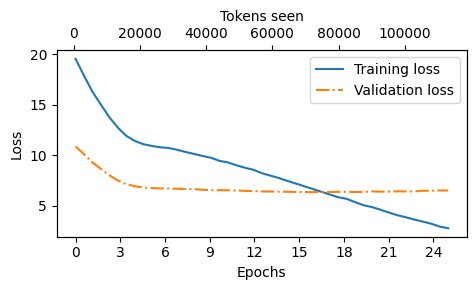

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def _to_list(x):
    if torch.is_tensor(x):
        # avoids .numpy() so no NumPy dependency
        return x.detach().cpu().tolist()
    # handle lists/tuples already
    return x


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(_to_list(epochs_tensor), _to_list(tokens_seen), _to_list(train_losses), _to_list(val_losses))

##### Generate new output

### Save Model State

Store the model state (weights) and optimizer state

In [3]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

NameError: name 'model' is not defined

In [5]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(cfg)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

NameError: name 'device' is not defined

In [ ]:
# Train again loaded model for 1 step.
train_losses, val_losses, tokens_seen = train_model_simple(
    gpt, train_loader, val_loader, optimizer, device,
    num_epochs=1, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

NameError: name 'train_model_simple' is not defined

### Assign Weights from pre-trained GPT2 model

In [ ]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12, "file_name": "gpt2-small-124M.pth"},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16, "file_name": "gpt2-medium-355M.pth"},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20, "file_name": "gpt2-large-774M.pth"},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25, "file_name": "gpt2-xl-1558M.pth"},
}

In [67]:
import os
import urllib
model_name = "gpt2-xl (1558M)"
file_name = model_configs[model_name]["file_name"]
NEW_CONFIG = cfg.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024})
NEW_CONFIG.update({"qkv_bias": True})

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

gpt = GPTModel(NEW_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device)


torch.manual_seed(123)

token_ids = generateText(
    model=gpt,
    idx=textToTokenIds("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", tokenIdsToText(token_ids, tokenizer))


Output text:
 Every effort moves you closer… You are all here for us… Please take us to God!" she cried.
But they knew to hold the


### Evaluate GPT 2 checkpoint loss on the Shakespeare dataset

In [ ]:

train_loss, val_loss = evaluate_model(
    gpt, train_loader, val_loader, device, eval_iter=5
)
print(f"Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}")

Train loss: 6.783, Val loss: 3.540
